<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC3_2020_NB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [0]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-06-15 22:15:40--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.150, 141.108.26.1
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K  --.-KB/s    in 0.06s   

2020-06-15 22:15:41 (1.40 MB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-06-15 22:15:43--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  7.28MB/s    in 2.5s    

2020-06-15 22:15:46 (7.28 MB/s) - ‘ising2_conf.dat’ saved [19060775/19060

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(tf.__version__)

2.2.0


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


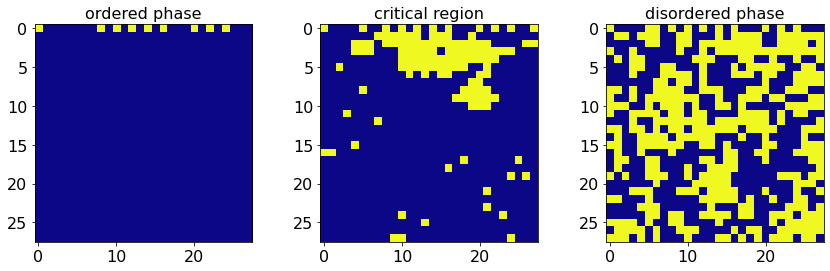

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [0]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

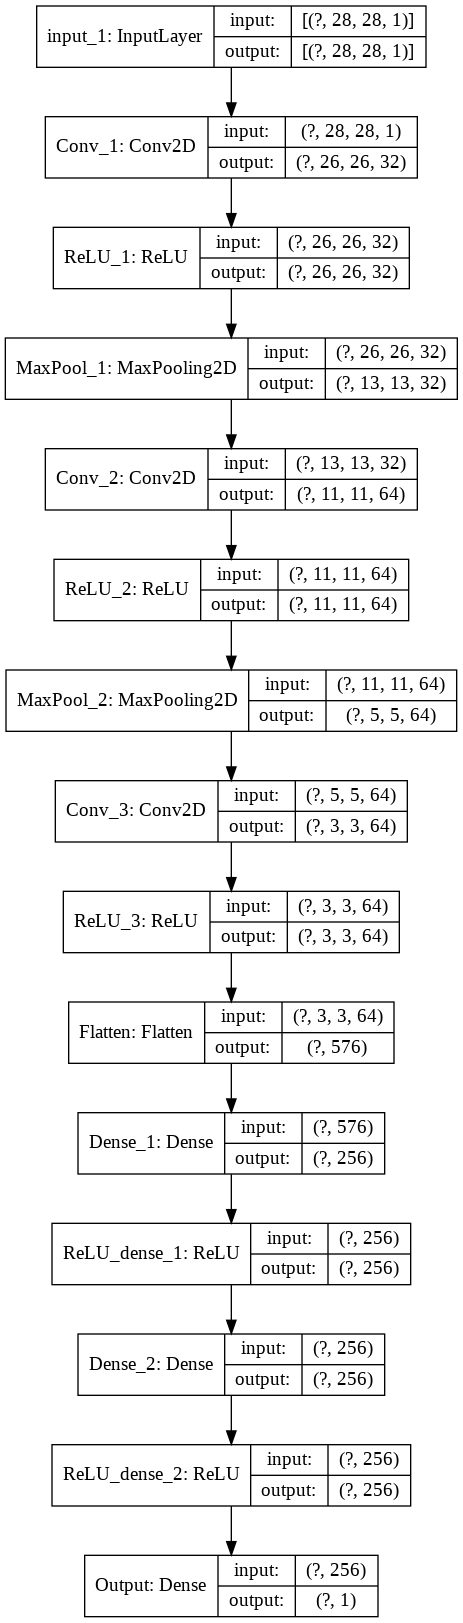

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
#x = data_augmentation(inputs)
x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

#
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
#tf.keras.layers.Conv2D(
#    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
#    dilation_rate=(1, 1), activation=None, use_bias=True,
#    kernel_initializer='glorot_uniform', bias_initializer='zeros',
#    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
#    kernel_constraint=None, bias_constraint=None, **kwargs
#)
#tf.keras.layers.ReLU(
#    max_value=None, negative_slope=0, threshold=0, **kwargs
#)
#tf.keras.layers.MaxPool2D(
#    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
#)
# NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
# ridurre la size dell'immagine dopo lapplicazione del filtro

#
# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

# Layer denso in Keras
#tf.keras.layers.Dense(
#    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
#    **kwargs
#)
x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ model_checkpoint ]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 13ms/step - loss: 0.6874 - mean_absolute_error: 0.5891 - val_loss: 0.2386 - val_mean_absolute_error: 0.4212
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2218 - mean_absolute_error: 0.4007 - val_loss: 0.2221 - val_mean_absolute_error: 0.3979
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1911 - mean_absolute_error: 0.3606 - val_loss: 0.1607 - val_mean_absolute_error: 0.3330
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1398 - mean_absolute_error: 0.3035 - val_loss: 0.1374 - val_mean_absolute_error: 0.3015
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1335 - mean_absolute_error: 0.2927 - val_loss: 0.1815 - val_mean_absolute_error: 0.3450
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1186 - mean_absolute_error: 0.2755 - val_loss: 0.1288 - val_mean_absolute_error: 0.2912
Epoch 7/30
50/50 [=========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('mycnn_29')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0870 - mean_absolute_error: 0.2238

Test loss (MSE): 0.08695144951343536

Test MAE: 0.2238280177116394


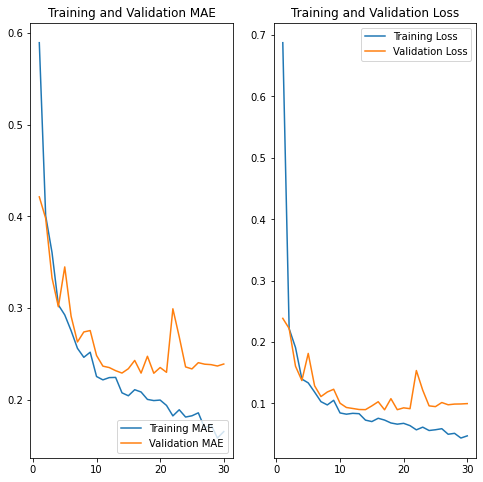

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.669659 VS 0.137200 Diff= 0.532459
Predicted vs True T: 3.487975 VS 3.240970 Diff= 0.247005
Predicted vs True T: 1.666879 VS 2.009980 Diff= -0.343101
Predicted vs True T: 3.980708 VS 4.218530 Diff= -0.237822
Predicted vs True T: 3.845986 VS 4.301270 Diff= -0.455284
Predicted vs True T: 3.758036 VS 3.531690 Diff= 0.226346
Predicted vs True T: 4.225634 VS 4.413820 Diff= -0.188186
Predicted vs True T: 2.835124 VS 3.045540 Diff= -0.210417
Predicted vs True T: 2.988204 VS 2.872210 Diff= 0.115994
Predicted vs True T: 4.317863 VS 4.120840 Diff= 0.197022
Sample MAE:  [0.27536362]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9765


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

**Trovare gi iprparametri ottimali del modello con** *Keras Tuner*

Dato un modello funzionante il passo successivo è quello di ottimizzarne l'archiettura. Questo può essere fatto manualmente (alcuni esempi li abbiamo visti sopra intorducendo il decay del learning rate o introducendo procedure di data_augmentation), oppure in modo sistematico usando tool appositi. Uno di tali tool, semplice e che funziona con keras è appunto [*Keras Tuner*](https://keras-team.github.io/keras-tuner/)


Uso:

1.   si modifica la definizione del modello in modo che acectti un parametro *hp* e in modo tale da modificare gli iperparametri del modello in accordo a diversi metodi di sampling *(hp.Int(), hp.Choice(), ...)*  
2.   si istanzia un oggetto di tipo *tuner* che definisce la strategia di tuning da seguire
3.   si fa partire la ricerca dei parametri e si prina il risultato finale

Esempio pratico:

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

'''def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.ReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.ReLU()(x)
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model'''

"def build_model(hp):\n  inputs = keras.Input(shape=(28,28,1))\n  x = keras.layers.Conv2D(\n      filters=hp.Int('filters', min_value=32, max_value=128, step=32),\n      kernel_size=(3,3))(inputs)\n  x = keras.layers.ReLU()(x)\n  x = keras.layers.MaxPool2D((2,2))(x)\n  x = keras.layers.Flatten()(x)\n  x = keras.layers.Dense(\n      units=hp.Int('units', min_value=32, max_value=512, step=32)\n      )(x)\n  x = keras.layers.ReLU()(x)\n  outputs = keras.layers.Dense(1)(x)\n\n  model = keras.Model(inputs=inputs, outputs=outputs)\n  \n  model.compile(\n        optimizer=keras.optimizers.Adam(\n          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),\n        loss='mse',\n        metrics=['mae'])\n  return model"

In [0]:
#pip install -U keras-tuner

In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
'''import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='ottim_dir')'''

"import kerastuner\n \ntuner = kerastuner.tuners.RandomSearch(\n  build_model,\n  objective='val_loss',\n  max_trials=10,\n  executions_per_trial=2,\n  directory='ottim_dir')"

In [0]:
# start optimisation search
#X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

#tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

In [0]:
# Results
#tuner.results_summary()

In [0]:
# Retrieve the best models
'''models = tuner.get_best_models(num_models=2)

test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)'''

"models = tuner.get_best_models(num_models=2)\n\ntest_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)\nprint('\nTest loss (MSE):', test_loss)\nprint('\nTest MAE:', test_mae)"

**Batch Normalization Layers**

Servono a normalizzare gli output del layer precedente in ogni batch: mantengono la media degli output vicina a zero (in ciascun batch) e la deviazione standard vicina a 1. Questo minimizza effetti di diluzione del gradiente e accelera la convergenza (oltre ad avare un effetto di smoothing sulla funzione di loss stimata con il batch di eventi)


In [0]:
#Esempio uso batch normalisation layers
#tf.keras.layers.BatchNormalization(
#    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
#    beta_initializer='zeros', gamma_initializer='ones',
#    moving_mean_initializer='zeros', moving_variance_initializer='ones',
#    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
#    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
#    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
#    **kwargs
#)

#  x = keras.layers.Conv2D(32, kernel_size=(3,3))(x)
#  x = keras.layers.BatchNormalization()(x)
#  x = keras.layers.ReLU(x)

#**Utilizzo della call-back del learning rate con decay**

Testiamo in primo luogo l'utilizzo di una callback che includa un meccanismo di learning-rate decay: impostiamo cioè un learning rate fisso per Adam per le prime 10 epoche del training, mentre per le successive esso diminuisce esponenzialmente con il numero di epoche. Grafichiamo quindi mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

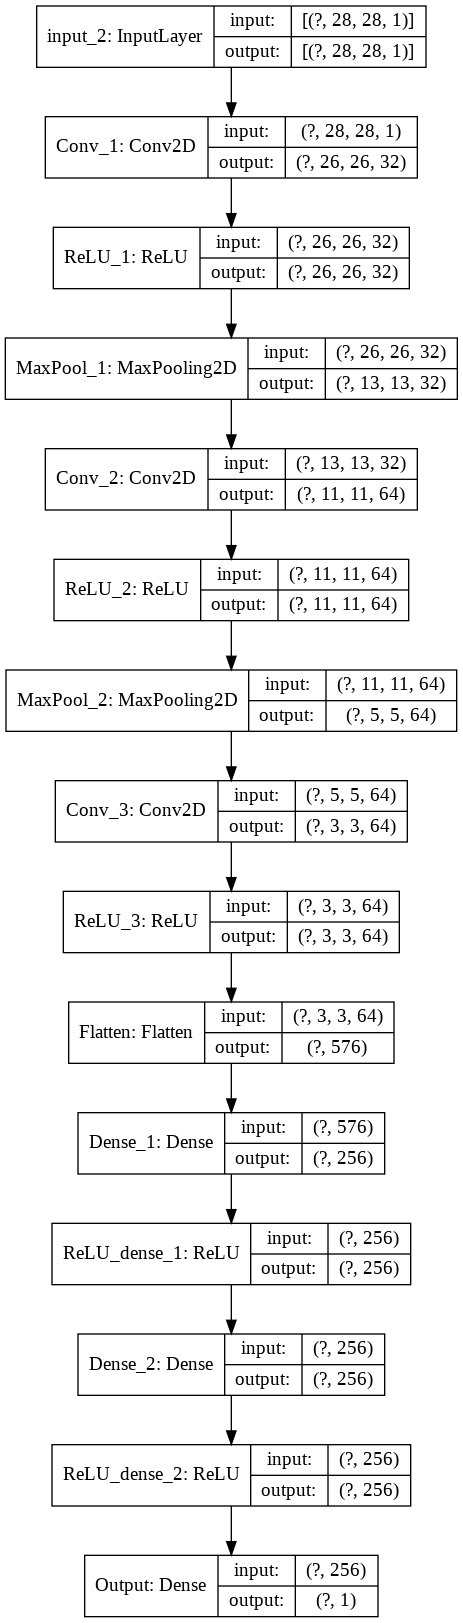

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae

mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
callbacks = [model_checkpoint, lr_scheduler]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.6878 - mean_absolute_error: 0.5854 - val_loss: 0.2415 - val_mean_absolute_error: 0.4176 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.2069 - mean_absolute_error: 0.3846 - val_loss: 0.1774 - val_mean_absolute_error: 0.3573 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1539 - mean_absolute_error: 0.3192 - val_loss: 0.1400 - val_mean_absolute_error: 0.3037 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1335 - mean_absolute_error: 0.2926 - val_loss: 0.1377 - val_mean_absolute_error: 0.2980 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1266 - mean_absolute_error: 0.2804 - val_loss: 0.1141 - val_mean_absolute_error: 0.2664 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1045 - mean_absolute_error: 0.2523 - val_loss: 0.10

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0821 - mean_absolute_error: 0.2198

Test loss (MSE): 0.08214250952005386

Test MAE: 0.2197510004043579


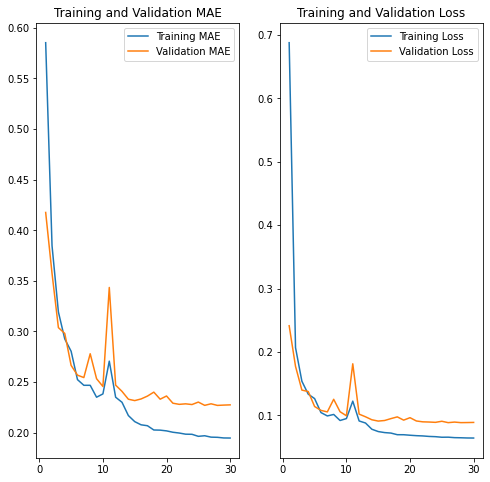

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Osserviamo che, a partire dalla ventesima epoca, le curve di entrambi i campioni non presentano più dei picchi, come accadeva in precedenza, ma tendono a dei valori costanti, come ci aspettiamo che accada usando una CNN funzionante. Tuttavia, le differenze tra i valori asintotici di *mae* e *mse* dei campioni di training e di test sono particolarmente elevate, il che può essere riconducibile a problemi di overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.656954 VS 0.137200 Diff= 0.519754
Predicted vs True T: 3.452306 VS 3.240970 Diff= 0.211336
Predicted vs True T: 1.771113 VS 2.009980 Diff= -0.238867
Predicted vs True T: 4.073161 VS 4.218530 Diff= -0.145369
Predicted vs True T: 4.188529 VS 4.301270 Diff= -0.112741
Predicted vs True T: 3.749264 VS 3.531690 Diff= 0.217574
Predicted vs True T: 4.412612 VS 4.413820 Diff= -0.001207
Predicted vs True T: 3.114084 VS 3.045540 Diff= 0.068543
Predicted vs True T: 3.155874 VS 2.872210 Diff= 0.283664
Predicted vs True T: 4.782472 VS 4.120840 Diff= 0.661632
Sample MAE:  [0.24606887]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9815


L'accuracy sul campione di test aumenta leggermente rispetto al caso in cui non si utilizzi il learning-rate decay.

#**Utilizzo della data-augmentation**

Proviamo ora a modificare la CNN aggiungendo un layer di data augmentation. Dati i risultati incoraggianti ottenuti in precedenza, manteniamo il learning-rate decay. Grafichiamo nuovamente mse e mae dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 11, 11, 64)        0 

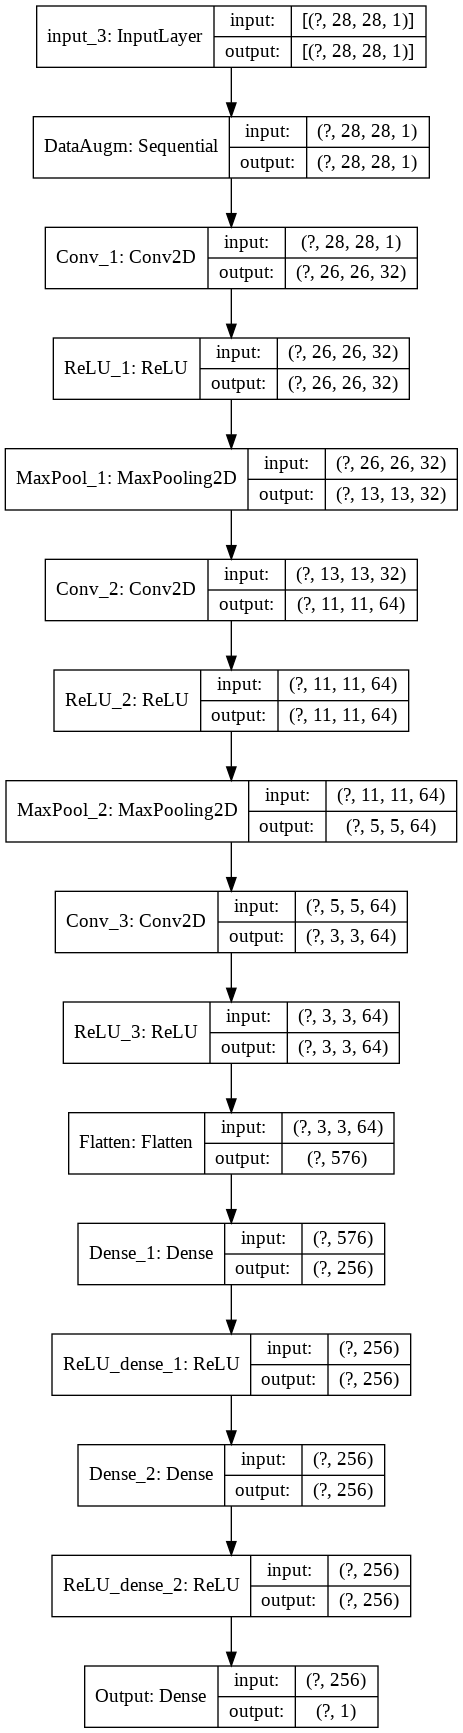

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [lr_scheduler, model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.8758 - mean_absolute_error: 0.6642 - val_loss: 0.2626 - val_mean_absolute_error: 0.4307 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2371 - mean_absolute_error: 0.4139 - val_loss: 0.2279 - val_mean_absolute_error: 0.4103 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2097 - mean_absolute_error: 0.3886 - val_loss: 0.2103 - val_mean_absolute_error: 0.3788 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1757 - mean_absolute_error: 0.3472 - val_loss: 0.1561 - val_mean_absolute_error: 0.3229 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1329 - mean_absolute_error: 0.2927 - val_loss: 0.1415 - val_mean_absolute_error: 0.3009 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1183 - mean_absolute_error: 0.2727 - val_loss: 0.11

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0784 - mean_absolute_error: 0.2153

Test loss (MSE): 0.07843466103076935

Test MAE: 0.21525529026985168


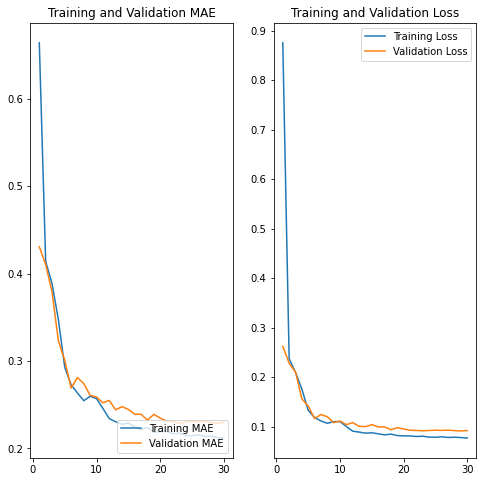

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notiamo che ora non solo le curve non presentano più dei picchi, una volta raggiunto il valore asintotico, ma che questo è molto simile per i campioni di training e di validazione, sia per il *mse* che per il *mae*: abbiamo quindi risolto i problemi di overfitting della rete.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.646423 VS 0.137200 Diff= 0.509223
Predicted vs True T: 3.434419 VS 3.240970 Diff= 0.193449
Predicted vs True T: 1.797122 VS 2.009980 Diff= -0.212858
Predicted vs True T: 4.152663 VS 4.218530 Diff= -0.065867
Predicted vs True T: 4.401090 VS 4.301270 Diff= 0.099820
Predicted vs True T: 3.680193 VS 3.531690 Diff= 0.148504
Predicted vs True T: 4.491051 VS 4.413820 Diff= 0.077231
Predicted vs True T: 2.953646 VS 3.045540 Diff= -0.091894
Predicted vs True T: 3.094645 VS 2.872210 Diff= 0.222435
Predicted vs True T: 4.703012 VS 4.120840 Diff= 0.582172
Sample MAE:  [0.22034526]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9795


Anche in questo caso, l'accuracy è aumentata, sebbene di poco, rispetto alla stima ottenuta con la prima rete.

#**Utilizzo di diverse funzioni di attivazione**

Testiamo ora la performance della rete utilizzando diverse funzioni di attivazione. Ci concentreremo, in particolare, sulla tangente iperbolica, LeakyReLU ed ELU. In tutte le prove che effettueremo manterremo l'utilizzo del layer di data augmentation, nonché del learning-rate decay.

**Tangente iperbolica**

Proviamo per prima la tangente iperbolica.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
tanh_1 (Activation)          (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
tanh_2 (Activation)          (None, 11, 11, 64)        0 

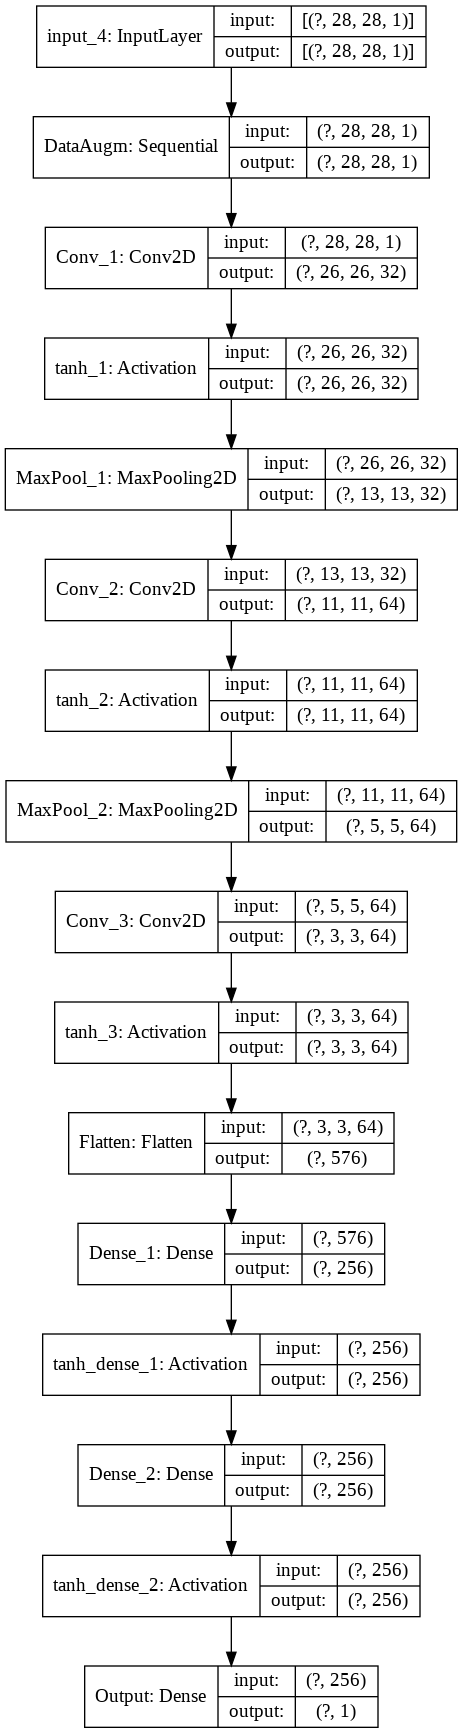

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.Activation('tanh', name='tanh_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.Activation('tanh', name='tanh_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.Activation('tanh', name='tanh_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.Activation('tanh', name='tanh_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.7325 - mean_absolute_error: 0.6241 - val_loss: 0.2294 - val_mean_absolute_error: 0.4080 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.2006 - mean_absolute_error: 0.3748 - val_loss: 0.2267 - val_mean_absolute_error: 0.3838 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1661 - mean_absolute_error: 0.3314 - val_loss: 0.1940 - val_mean_absolute_error: 0.3524 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 10ms/step - loss: 0.1522 - mean_absolute_error: 0.3127 - val_loss: 0.1489 - val_mean_absolute_error: 0.3038 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1412 - mean_absolute_error: 0.2983 - val_loss: 0.1698 - val_mean_absolute_error: 0.3162 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1165 - mean_absolute_error: 0.2705 - val_loss: 0.1

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0887 - mean_absolute_error: 0.2327

Test loss (MSE): 0.0887046679854393

Test MAE: 0.23266498744487762


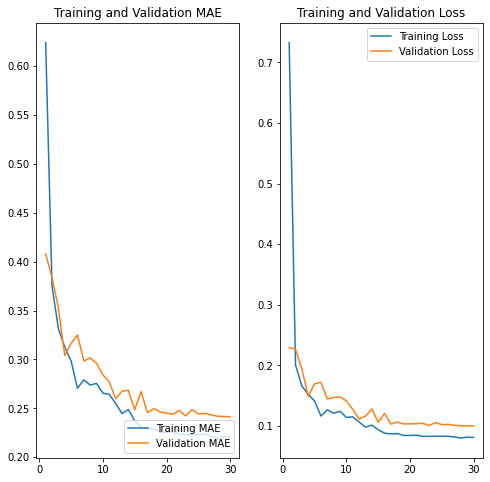

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

L'andamento riscontrato continua ad essere sufficientemente *smooth*. La rete restituisce anche in questo caso delle curve di *mae* e *mse* valide, che non danno segni di evidente overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.688338 VS 0.137200 Diff= 0.551138
Predicted vs True T: 3.453531 VS 3.240970 Diff= 0.212561
Predicted vs True T: 1.822908 VS 2.009980 Diff= -0.187072
Predicted vs True T: 4.273530 VS 4.218530 Diff= 0.055000
Predicted vs True T: 4.201838 VS 4.301270 Diff= -0.099432
Predicted vs True T: 3.773063 VS 3.531690 Diff= 0.241373
Predicted vs True T: 4.370804 VS 4.413820 Diff= -0.043016
Predicted vs True T: 2.723768 VS 3.045540 Diff= -0.321772
Predicted vs True T: 3.174830 VS 2.872210 Diff= 0.302620
Predicted vs True T: 4.556321 VS 4.120840 Diff= 0.435481
Sample MAE:  [0.24494651]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.976


L'accuracy sul campione di test rimane pressoché invariata.

**LeakyReLU**

Passiamo allo studio di LeakyReLU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 11, 11, 64)        0 

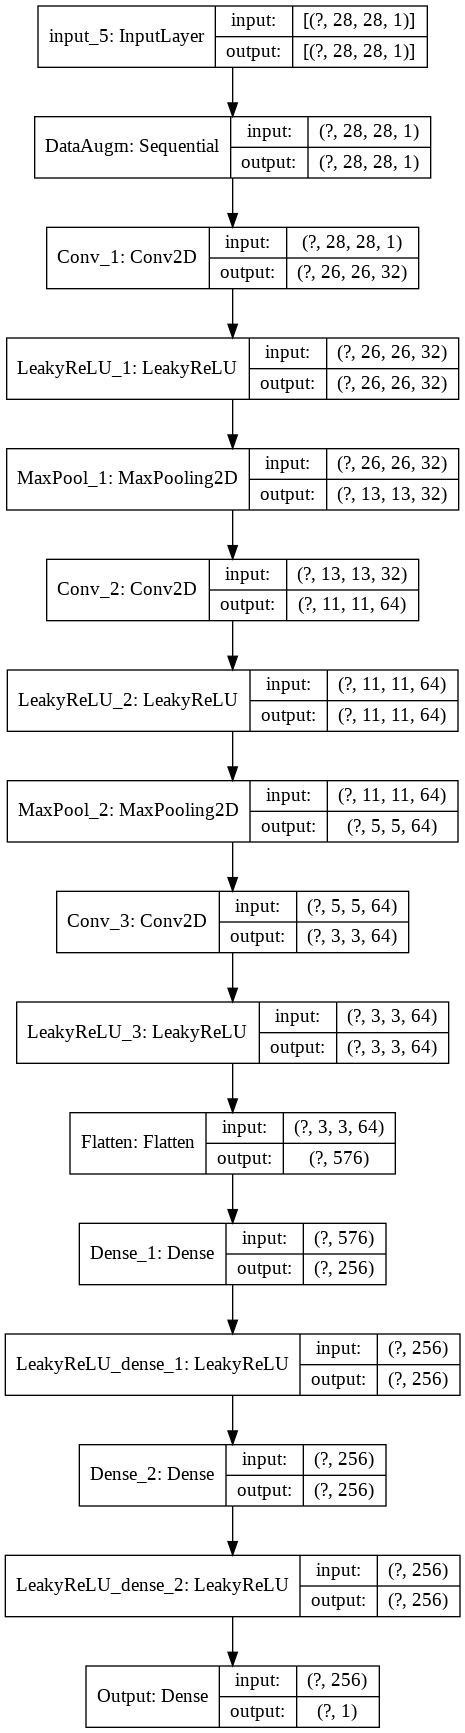

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.LeakyReLU(name='LeakyReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.9595 - mean_absolute_error: 0.6958 - val_loss: 0.2681 - val_mean_absolute_error: 0.4414 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 8ms/step - loss: 0.2247 - mean_absolute_error: 0.4011 - val_loss: 0.1892 - val_mean_absolute_error: 0.3597 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1759 - mean_absolute_error: 0.3429 - val_loss: 0.1627 - val_mean_absolute_error: 0.3205 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1389 - mean_absolute_error: 0.2997 - val_loss: 0.1387 - val_mean_absolute_error: 0.2986 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1500 - mean_absolute_error: 0.3087 - val_loss: 0.1445 - val_mean_absolute_error: 0.2984 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1272 - mean_absolute_error: 0.2843 - val_loss: 0.13

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0843 - mean_absolute_error: 0.2241

Test loss (MSE): 0.08428840339183807

Test MAE: 0.22408781945705414


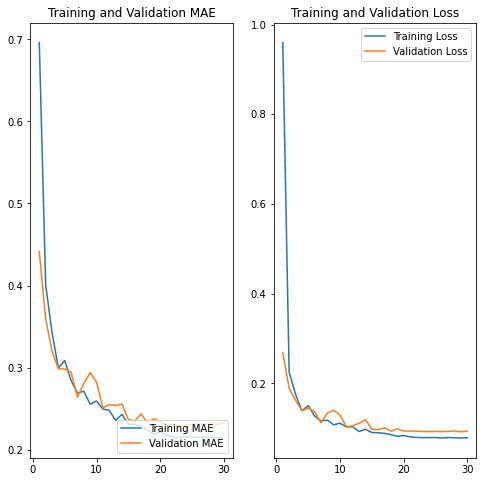

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* del campione di training e di quello di validazione convergono già prima della ventesima epoca, migliorando i risultati ottenuti fino ad ora. Risultando quasi sovrapponibili, possiamo presumere che non sia presente overfitting.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.671234 VS 0.137200 Diff= 0.534034
Predicted vs True T: 3.425397 VS 3.240970 Diff= 0.184427
Predicted vs True T: 1.724989 VS 2.009980 Diff= -0.284991
Predicted vs True T: 4.368312 VS 4.218530 Diff= 0.149782
Predicted vs True T: 4.099814 VS 4.301270 Diff= -0.201456
Predicted vs True T: 3.811319 VS 3.531690 Diff= 0.279629
Predicted vs True T: 4.404081 VS 4.413820 Diff= -0.009738
Predicted vs True T: 2.986732 VS 3.045540 Diff= -0.058808
Predicted vs True T: 3.283635 VS 2.872210 Diff= 0.411425
Predicted vs True T: 4.499124 VS 4.120840 Diff= 0.378284
Sample MAE:  [0.24925737]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.983


L'accuracy sul campione di test aumenta rispetto al caso della rete con ReLU.

**ELU**

Infine, implementiamo ELU.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
ELU_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
ELU_2 (ELU)                  (None, 11, 11, 64)        0 

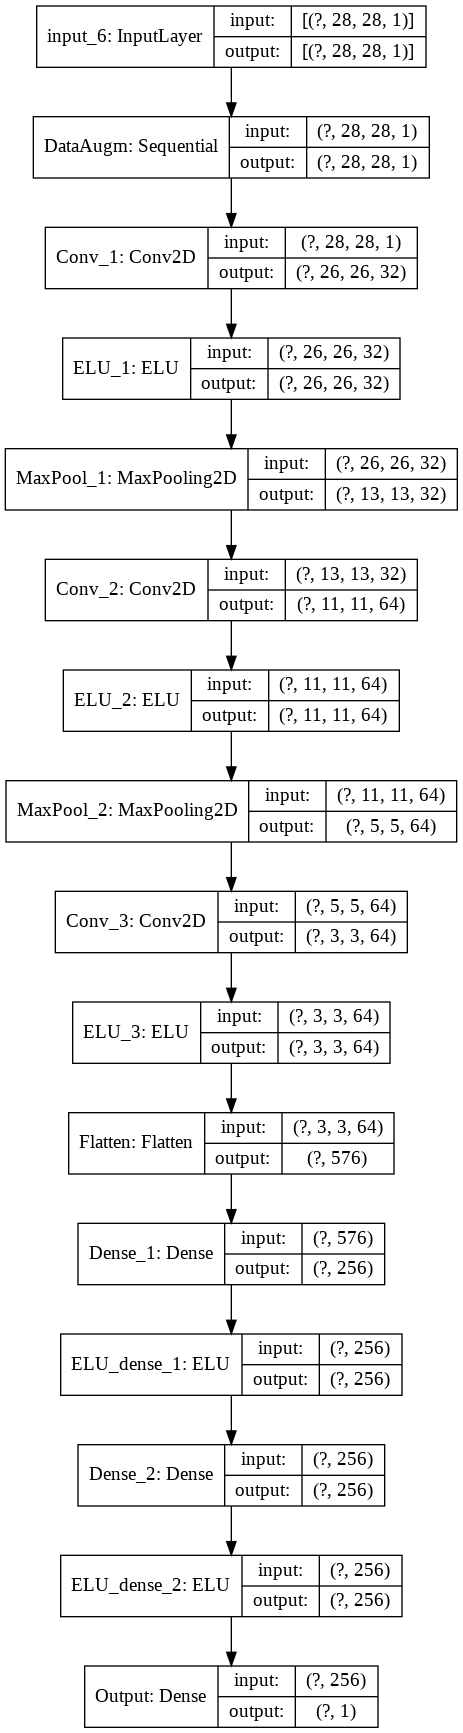

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

x = data_augmentation(inputs)

# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore

# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: tangente iperbolica

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.ELU(name='ELU_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.ELU(name='ELU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ELU(name='ELU_3')(x)

# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ELU(name='ELU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ELU(name='ELU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# callback per avere un leraning rate variabile

# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
callbacks = [lr_scheduler, model_checkpoint]
#callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 0s 8ms/step - loss: 0.6047 - mean_absolute_error: 0.5721 - val_loss: 0.2402 - val_mean_absolute_error: 0.4064 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1950 - mean_absolute_error: 0.3650 - val_loss: 0.1757 - val_mean_absolute_error: 0.3508 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1524 - mean_absolute_error: 0.3169 - val_loss: 0.1613 - val_mean_absolute_error: 0.3223 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.1268 - mean_absolute_error: 0.2859 - val_loss: 0.1267 - val_mean_absolute_error: 0.2846 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1232 - mean_absolute_error: 0.2800 - val_loss: 0.1591 - val_mean_absolute_error: 0.3160 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.1251 - mean_absolute_error: 0.2799 - val_loss: 0.14

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
# (i.e. quello che aveva la minore loss in validazione) in questo caso l'epoca 29
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0873 - mean_absolute_error: 0.2305

Test loss (MSE): 0.08731672167778015

Test MAE: 0.23052848875522614


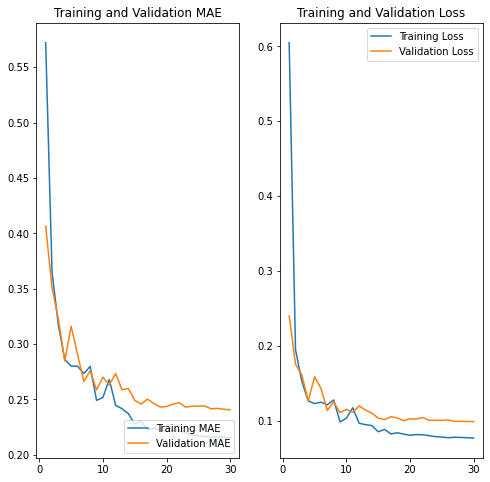

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* convergono anche utilizzando ELU come funzione di attivazione, sebbene tale convergenza sia ora più tardiva e gli andamenti non siano perfettamente sovrapponibili (come abbiamo osservato, invece, con LeakyReLU).

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.717125 VS 0.137200 Diff= 0.579925
Predicted vs True T: 3.634834 VS 3.240970 Diff= 0.393864
Predicted vs True T: 1.706367 VS 2.009980 Diff= -0.303613
Predicted vs True T: 4.237224 VS 4.218530 Diff= 0.018693
Predicted vs True T: 4.415168 VS 4.301270 Diff= 0.113898
Predicted vs True T: 3.771706 VS 3.531690 Diff= 0.240016
Predicted vs True T: 4.459087 VS 4.413820 Diff= 0.045268
Predicted vs True T: 2.903323 VS 3.045540 Diff= -0.142217
Predicted vs True T: 3.362592 VS 2.872210 Diff= 0.490381
Predicted vs True T: 4.483767 VS 4.120840 Diff= 0.362926
Sample MAE:  [0.26908016]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.9785


L'accuracy sul campione di test aumenta leggermente.

#**Utilizzo di Keras Tuner**

Per ottimizzare la rete creata, utilizziamo la tecnica del tuning degli iperparametri, mediante *keras tuner*. Modifichiamo la rete in modo che accetti un parametro (ovvero un iperparametro) che possa essere ottimizzato dal *tuner*. Si fa dunque iterare l'algoritmo più volte, in modo da ottenere la migliore stima del parametro da utilizzare. <br />
Anche in questo caso manteniamo il layer di data augmentation ed il learning-rate decay. Sostituiamo però la funzione di attivazione ReLU con LeakyReLU, in quanto abbiamo ottenuto risultati migliori con essa.

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  x = data_augmentation(inputs)

  #first convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=16, max_value=128, step=16),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #second convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPool2D((2,2))(x)

  #third convolutional block
  x = keras.layers.Conv2D(
      filters=hp.Int('filters', min_value=32, max_value=128, step=32),
      kernel_size=(3,3))(inputs)
  x = keras.layers.LeakyReLU()(x)
  #x = keras.layers.MaxPool2D((2,2))(x)

  x = keras.layers.Flatten()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  x = keras.layers.Dense(
      units=hp.Int('units', min_value=32, max_value=512, step=32)
      )(x)
  x = keras.layers.LeakyReLU()(x)
  
  outputs = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
  return model

In [0]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=deae6bf9930075503607b9db5dd19ecc87d4f39c0f6c29dde2bb158a7ec4f579
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=f8ffdcd1820dbef58dc4f949721b219e1ce6b5efc47262fbfc57011449806d96
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_loss',
  max_trials=10,
  executions_per_trial=2,
  directory='dir')

In [0]:
# start optimisation search
X_t,X_v,Y_t,Y_v=train_test_split(X_train,Y_train,train_size=0.5)

tuner.search(X_t, Y_t, epochs=10, validation_data=(X_v, Y_v))

Epoch 1/10
125/125 [==============================] - 3s 26ms/step - loss: 3861.0842 - mae: 20.0128 - val_loss: 5.3711 - val_mae: 1.8777
Epoch 2/10
125/125 [==============================] - 3s 26ms/step - loss: 0.9690 - mae: 0.7597 - val_loss: 0.4136 - val_mae: 0.4973
Epoch 3/10
125/125 [==============================] - 3s 25ms/step - loss: 0.4897 - mae: 0.5383 - val_loss: 0.2872 - val_mae: 0.4281
Epoch 4/10
125/125 [==============================] - 2s 19ms/step - loss: 0.4104 - mae: 0.5008 - val_loss: 0.6934 - val_mae: 0.6913
Epoch 5/10
125/125 [==============================] - 3s 25ms/step - loss: 3.6434 - mae: 1.1757 - val_loss: 0.2551 - val_mae: 0.4087
Epoch 6/10
125/125 [==============================] - 2s 19ms/step - loss: 0.5618 - mae: 0.5484 - val_loss: 0.3142 - val_mae: 0.4527
Epoch 7/10
125/125 [==============================] - 2s 19ms/step - loss: 2.4583 - mae: 1.0252 - val_loss: 0.3437 - val_mae: 0.4598
Epoch 8/10
125/125 [==============================] - 2s 19ms/ste

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 0.9454 - mae: 0.6025 - val_loss: 0.2172 - val_mae: 0.3890
Epoch 2/10
125/125 [==============================] - 1s 5ms/step - loss: 0.1604 - mae: 0.3196 - val_loss: 0.2190 - val_mae: 0.3738
Epoch 3/10
125/125 [==============================] - 5s 37ms/step - loss: 0.1389 - mae: 0.2952 - val_loss: 0.1862 - val_mae: 0.3410
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1089 - mae: 0.2579 - val_loss: 0.2026 - val_mae: 0.3633
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0785 - mae: 0.2171 - val_loss: 0.1439 - val_mae: 0.2986
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 0.0670 - mae: 0.1984 - val_loss: 0.1913 - val_mae: 0.3482
Epoch 7/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0623 - mae: 0.1875 - val_loss: 0.1734 - val_mae: 0.3296
Epoch 8/10
125/125 [==============================] - 1s 5ms/step - loss: 0

Epoch 1/10
125/125 [==============================] - 2s 19ms/step - loss: 1654.6360 - mae: 12.4589 - val_loss: 1.6164 - val_mae: 0.9968
Epoch 2/10
125/125 [==============================] - 2s 19ms/step - loss: 1.1206 - mae: 0.8360 - val_loss: 0.6909 - val_mae: 0.6752
Epoch 3/10
125/125 [==============================] - 2s 19ms/step - loss: 0.6346 - mae: 0.6327 - val_loss: 0.5975 - val_mae: 0.6317
Epoch 4/10
125/125 [==============================] - 2s 16ms/step - loss: 0.8830 - mae: 0.7142 - val_loss: 5.8089 - val_mae: 2.0179
Epoch 5/10
125/125 [==============================] - 2s 19ms/step - loss: 1.2435 - mae: 0.8166 - val_loss: 0.4571 - val_mae: 0.5242
Epoch 6/10
125/125 [==============================] - 2s 19ms/step - loss: 0.3547 - mae: 0.4561 - val_loss: 0.2373 - val_mae: 0.3665
Epoch 7/10
125/125 [==============================] - 2s 16ms/step - loss: 3.3025 - mae: 1.2414 - val_loss: 2.1793 - val_mae: 1.0848
Epoch 8/10
125/125 [==============================] - 2s 16ms/ste

Epoch 1/10
125/125 [==============================] - 2s 13ms/step - loss: 0.5109 - mae: 0.5198 - val_loss: 0.2358 - val_mae: 0.3963
Epoch 2/10
125/125 [==============================] - 2s 13ms/step - loss: 0.1673 - mae: 0.3278 - val_loss: 0.1936 - val_mae: 0.3578
Epoch 3/10
125/125 [==============================] - 1s 11ms/step - loss: 0.1236 - mae: 0.2762 - val_loss: 0.2045 - val_mae: 0.3632
Epoch 4/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0960 - mae: 0.2408 - val_loss: 0.1670 - val_mae: 0.3300
Epoch 5/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0786 - mae: 0.2124 - val_loss: 0.1577 - val_mae: 0.3126
Epoch 6/10
125/125 [==============================] - 2s 14ms/step - loss: 0.0760 - mae: 0.2073 - val_loss: 0.1519 - val_mae: 0.3043
Epoch 7/10
125/125 [==============================] - 1s 11ms/step - loss: 0.0648 - mae: 0.1871 - val_loss: 0.1543 - val_mae: 0.3142
Epoch 8/10
125/125 [==============================] - 2s 13ms/step - 

Epoch 1/10
125/125 [==============================] - 2s 12ms/step - loss: 4.3795 - mae: 0.9572 - val_loss: 0.2230 - val_mae: 0.3887
Epoch 2/10
125/125 [==============================] - 2s 13ms/step - loss: 0.2184 - mae: 0.3764 - val_loss: 0.1786 - val_mae: 0.3455
Epoch 3/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1435 - mae: 0.3018 - val_loss: 0.2468 - val_mae: 0.4175
Epoch 4/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1488 - mae: 0.3043 - val_loss: 0.2167 - val_mae: 0.3868
Epoch 5/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1405 - mae: 0.2982 - val_loss: 0.2457 - val_mae: 0.4079
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1119 - mae: 0.2624 - val_loss: 0.1896 - val_mae: 0.3428
Epoch 7/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1047 - mae: 0.2559 - val_loss: 0.1937 - val_mae: 0.3465
Epoch 8/10
125/125 [==============================] - 1s 10ms/step - 

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 0.4680 - mae: 0.4937 - val_loss: 0.1894 - val_mae: 0.3595
Epoch 2/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1494 - mae: 0.3111 - val_loss: 0.2026 - val_mae: 0.3675
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1357 - mae: 0.2897 - val_loss: 0.1637 - val_mae: 0.3312
Epoch 4/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1064 - mae: 0.2568 - val_loss: 0.1737 - val_mae: 0.3415
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0909 - mae: 0.2347 - val_loss: 0.1514 - val_mae: 0.3149
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0781 - mae: 0.2150 - val_loss: 0.1685 - val_mae: 0.3302
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0737 - mae: 0.2044 - val_loss: 0.1484 - val_mae: 0.3095
Epoch 8/10
125/125 [==============================] - 1s 6ms/step - loss: 0.

Epoch 1/10
125/125 [==============================] - 1s 7ms/step - loss: 1119.8468 - mae: 9.3614 - val_loss: 0.6603 - val_mae: 0.6202
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6128 - mae: 0.6089 - val_loss: 0.5261 - val_mae: 0.5760
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4383 - mae: 0.5213 - val_loss: 0.3733 - val_mae: 0.4756
Epoch 4/10
125/125 [==============================] - 2s 14ms/step - loss: 0.3256 - mae: 0.4504 - val_loss: 0.3137 - val_mae: 0.4413
Epoch 5/10
125/125 [==============================] - 1s 6ms/step - loss: 0.2493 - mae: 0.3933 - val_loss: 0.5587 - val_mae: 0.6051
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.3164 - mae: 0.4305 - val_loss: 0.2706 - val_mae: 0.4114
Epoch 7/10
125/125 [==============================] - 2s 14ms/step - loss: 0.1775 - mae: 0.3340 - val_loss: 0.2253 - val_mae: 0.3715
Epoch 8/10
125/125 [==============================] - 1s 6ms/step - los

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 130.0883 - mae: 3.7196 - val_loss: 0.7351 - val_mae: 0.6630
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.4396 - mae: 0.5148 - val_loss: 0.3860 - val_mae: 0.5032
Epoch 3/10
125/125 [==============================] - 1s 6ms/step - loss: 0.2492 - mae: 0.3975 - val_loss: 0.3946 - val_mae: 0.5184
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.3235 - mae: 0.4341 - val_loss: 0.3370 - val_mae: 0.4683
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.1976 - mae: 0.3470 - val_loss: 0.2113 - val_mae: 0.3630
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1577 - mae: 0.3148 - val_loss: 0.2670 - val_mae: 0.4288
Epoch 7/10
125/125 [==============================] - 1s 6ms/step - loss: 0.1615 - mae: 0.3103 - val_loss: 0.2147 - val_mae: 0.3651
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 

Epoch 1/10
125/125 [==============================] - 2s 16ms/step - loss: 2.3416 - mae: 0.7589 - val_loss: 0.2457 - val_mae: 0.3927
Epoch 2/10
125/125 [==============================] - 2s 17ms/step - loss: 0.1633 - mae: 0.3228 - val_loss: 0.1974 - val_mae: 0.3660
Epoch 3/10
125/125 [==============================] - 3s 24ms/step - loss: 0.1202 - mae: 0.2753 - val_loss: 0.1830 - val_mae: 0.3379
Epoch 4/10
125/125 [==============================] - 2s 17ms/step - loss: 0.1043 - mae: 0.2536 - val_loss: 0.1554 - val_mae: 0.3080
Epoch 5/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0734 - mae: 0.2105 - val_loss: 0.1703 - val_mae: 0.3201
Epoch 6/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0791 - mae: 0.2214 - val_loss: 0.1654 - val_mae: 0.3199
Epoch 7/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0627 - mae: 0.1903 - val_loss: 0.1624 - val_mae: 0.3122
Epoch 8/10
125/125 [==============================] - 2s 13ms/step - 

Epoch 1/10
125/125 [==============================] - 2s 12ms/step - loss: 3.1892 - mae: 0.8667 - val_loss: 0.1969 - val_mae: 0.3694
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 0.1660 - mae: 0.3266 - val_loss: 0.1976 - val_mae: 0.3514
Epoch 3/10
125/125 [==============================] - 2s 12ms/step - loss: 0.1336 - mae: 0.2898 - val_loss: 0.1692 - val_mae: 0.3256
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 0.1203 - mae: 0.2746 - val_loss: 0.1949 - val_mae: 0.3581
Epoch 5/10
125/125 [==============================] - 2s 12ms/step - loss: 0.0971 - mae: 0.2454 - val_loss: 0.1561 - val_mae: 0.3071
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0938 - mae: 0.2426 - val_loss: 0.2012 - val_mae: 0.3633
Epoch 7/10
125/125 [==============================] - 2s 13ms/step - loss: 0.0760 - mae: 0.2159 - val_loss: 0.1516 - val_mae: 0.3071
Epoch 8/10
125/125 [==============================] - 1s 11ms/step - 

INFO:tensorflow:Oracle triggered exit


In [0]:
# Results
tuner.results_summary()

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=2)

In [0]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

history = models[0].fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 14ms/step - loss: 0.1913 - mae: 0.3487 - val_loss: 0.2047 - val_mae: 0.3767 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 1s 23ms/step - loss: 0.1151 - mae: 0.2693 - val_loss: 0.1445 - val_mae: 0.3111 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 1s 21ms/step - loss: 0.0917 - mae: 0.2376 - val_loss: 0.1282 - val_mae: 0.2919 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0727 - mae: 0.2060 - val_loss: 0.1320 - val_mae: 0.2777 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 1s 13ms/step - loss: 0.0601 - mae: 0.1841 - val_loss: 0.1231 - val_mae: 0.2727 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0483 - mae: 0.1618 - val_loss: 0.1297 - val_mae: 0.2756 - lr: 0.0010
Epoch 7/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0480 - mae: 0.1559 - val_loss: 0.1163 - val_mae: 0.2707 - lr:

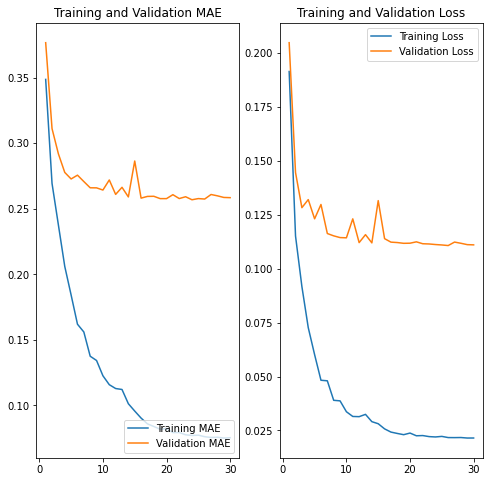

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mae']
val_mae = history.history['val_mae']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le curve di *mae* e *mse* del campione di validazione decrescono molto debolmente e non risultano sovrapponibili a quelle del campione di training.

In [0]:
test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.1210 - mae: 0.2709

Test loss (MSE): 0.12095897644758224

Test MAE: 0.27092695236206055


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = models[0].predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)

Accuracy is:  0.9625


L'accuracy sul campione di test scende, arrivando al 96.3$\%$.

#**Batch-Normalization layer**

Testiamo ora la stessa rete di partenza, ma con l'aggiunta di due *batch-normalization layers* nei primi due blocchi convoluzionali. Grafichiamo il *mse* e il *mae* dei campioni di training e di validazione.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
ReLu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        25

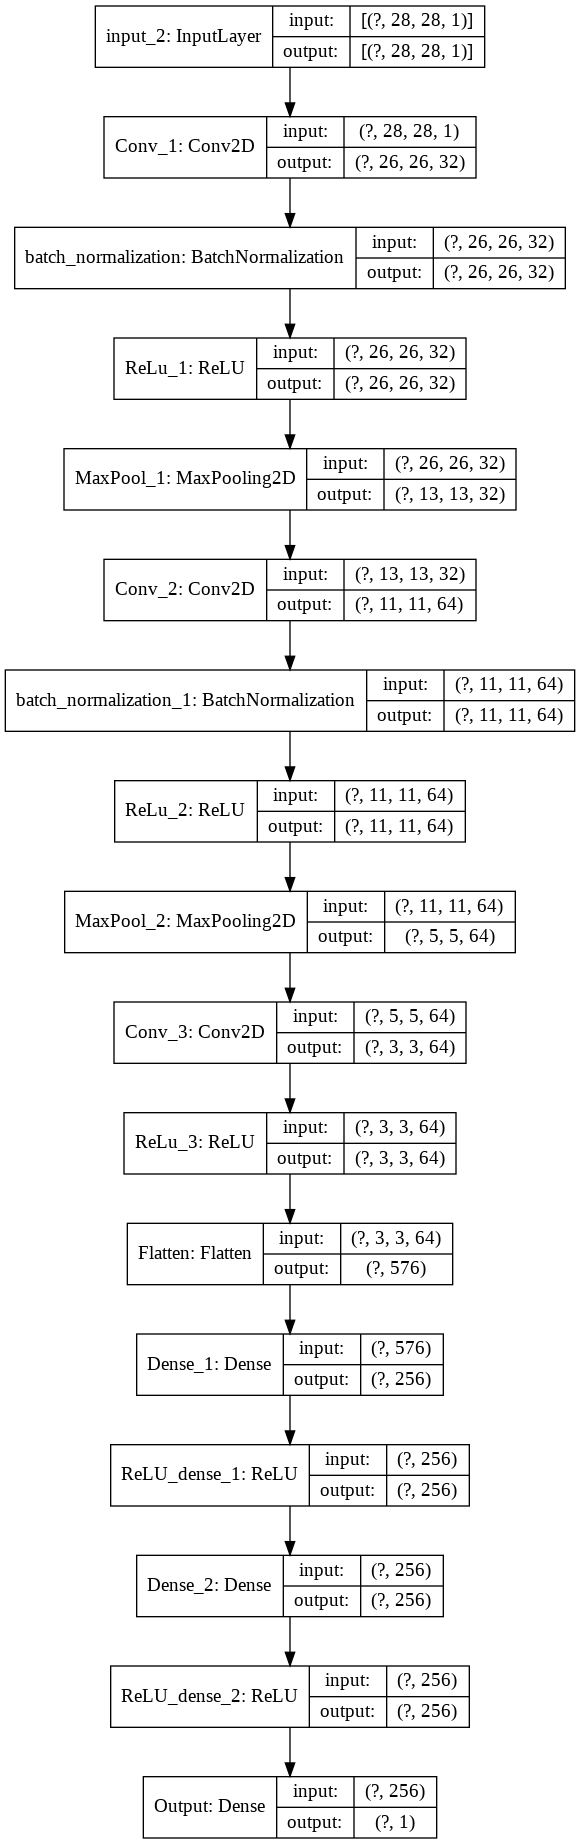

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

x = inputs


# CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
# da una rete densa come classificatore
# singolo blocco convoluzionale: conv2D + maxPooling 
# attvazione: ReLu

# primo blocco Convoluzionale
x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_1')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

# secondo blocco convoluzionale
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLu_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

# terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
# troppo la dimensione dell'output x)
x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
x = keras.layers.ReLU(name='ReLu_3')(x)


# appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
# vettore piatto come input per la rete densa

x = keras.layers.Flatten(name='Flatten')(x)

# rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
# layer di uscita costituito da 1 neurone con funzione di attivazione lineare
# che produce in output la stima della temperatura associata alla configurazione
# in input

x = keras.layers.Dense(256, name='Dense_1')(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)
x = keras.layers.Dense(256, name='Dense_2')(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)
outputs = keras.layers.Dense(1, name='Output')(x)

#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# learning rate per Adam
LR_ST=1e-3

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function: mse
mse = tf.keras.losses.MeanSquaredError()

# Metrica: mae
mae = tf.keras.metrics.MeanAbsoluteError()

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.2 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='best_epoch',
        verbose=0,
        save_weights_only=True, 
        save_freq='epoch',
        save_best_only=True,
        mode = 'min')

# metto tutte le callback in una lista
#callbacks = [model_checkpoint]
callbacks = [model_checkpoint]    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 11ms/step - loss: 0.6358 - mean_absolute_error: 0.5496 - val_loss: 5.5159 - val_mean_absolute_error: 1.9732
Epoch 2/30
50/50 [==============================] - 0s 8ms/step - loss: 0.2372 - mean_absolute_error: 0.3869 - val_loss: 5.9699 - val_mean_absolute_error: 2.0422
Epoch 3/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1880 - mean_absolute_error: 0.3369 - val_loss: 5.3557 - val_mean_absolute_error: 1.9404
Epoch 4/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1493 - mean_absolute_error: 0.3028 - val_loss: 4.3864 - val_mean_absolute_error: 1.7132
Epoch 5/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1961 - mean_absolute_error: 0.3479 - val_loss: 3.8491 - val_mean_absolute_error: 1.6138
Epoch 6/30
50/50 [==============================] - 0s 8ms/step - loss: 0.1248 - mean_absolute_error: 0.2747 - val_loss: 2.4898 - val_mean_absolute_error: 1.2499
Epoch 7/30
50/50 [=========

In [0]:
# carichiamo i parametri del modello migliore sul validation set 
model.load_weights('best_epoch')

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0927 - mean_absolute_error: 0.2327

Test loss (MSE): 0.09273165464401245

Test MAE: 0.2327425330877304


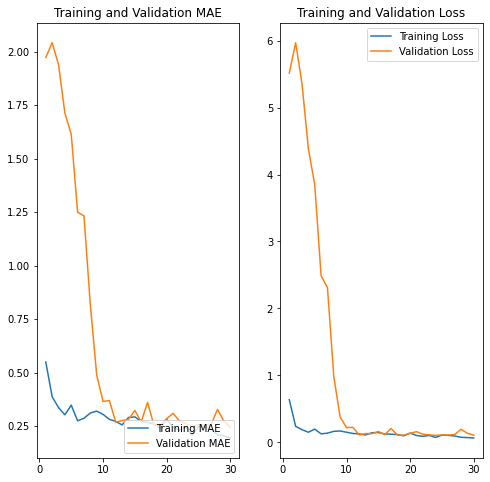

In [0]:
#plot della loss e della MAE durante il training

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

La convergneza delle curve è più rapida di quanto osservato in precedenza. Anche in questo caso non si riscontrano problemi di overfitting, ma i valori assunti dalle curve nella regione di convergenza sembrano variare di più rispetto al caso in cui si è implementata la *data augmentation*.

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)


Predicted vs True T: 0.688291 VS 0.137200 Diff= 0.551091
Predicted vs True T: 3.393481 VS 3.240970 Diff= 0.152512
Predicted vs True T: 1.679338 VS 2.009980 Diff= -0.330642
Predicted vs True T: 4.130319 VS 4.218530 Diff= -0.088211
Predicted vs True T: 4.125456 VS 4.301270 Diff= -0.175814
Predicted vs True T: 3.785405 VS 3.531690 Diff= 0.253715
Predicted vs True T: 4.028683 VS 4.413820 Diff= -0.385137
Predicted vs True T: 2.837040 VS 3.045540 Diff= -0.208500
Predicted vs True T: 3.280974 VS 2.872210 Diff= 0.408764
Predicted vs True T: 4.495659 VS 4.120840 Diff= 0.374819
Sample MAE:  [0.29292047]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc

T_c=2.26 # Temperatura critica

# predizioni della CNN sull'intero campione di Test
predictions = model.predict(X_test)


# conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
N_ord_corrette = 0 
N_dis_corrette = 0
N_all = 0
for i in range(predictions.shape[0]):
  if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
    N_ord_corrette = N_ord_corrette + 1
  if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
    N_dis_corrette = N_dis_corrette + 1

N_all = Y_test.shape[0]   

accuracy = (N_ord_corrette+N_dis_corrette)/N_all
print('Accuracy is: ', accuracy)



Accuracy is:  0.975


Anche in questo caso l'accuracy è calata rispetto al valore di riferimento del caso senza *data augmentation* e *batch-normalization layer*. La non perfetta convergenza delle curve di *mse* e *mae* può essere annoverata tra le possibili cause di questo calo.